# Music Recommendation

> I pledge my Honor that I have abided by the Stevens Honor System. - Mike DiGregorio & Joshua Schmidt

### dataset

To download the dataset follow the instructions here:
- https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data?select=members.csv.7z

If you are running archlinux:
- git clone https://aur.archlinux.org/kaggle-api.git
- cd kaggle-api
- makepkg -si
- Go to the first link and create a kaggle account and agree to the competition rules
- go to your account page on kaggle and create an api key and save the kaggle.json file in the folder ~/.kaggle/
- kaggle competitions download -c kkbox-music-recommendation-challenge

imports:

In [190]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.data as tfd


from loguru import logger
from tqdm import tqdm

from typing import List, Any, Tuple, Optional, Dict

In [191]:
datapath: str = os.path.join('..', 'data')

In [192]:
def list_files(directory: str, extension: str) -> List[str]:
    all_files = os.listdir(directory)
    return [os.path.join(directory, file) for file in all_files if file.split('.')[-1] == extension]

In [193]:
datasets: Dict[str, pd.DataFrame] = dict()
for filepath in tqdm(list_files(datapath, 'csv'), ascii=True, desc="Loading data from disk"):
    datasets[os.path.basename(filepath).split('.')[0]] = pd.read_csv(filepath)

Loading data from disk: 100%|##########| 6/6 [00:15<00:00,  2.59s/it]


In [194]:
print(f"Loaded {len(datasets)} csv files")
for key, value in datasets.items():
    print(f"length of dataset {key} is {len(value)}")

Loaded 6 csv files
length of dataset songs is 2296320
length of dataset test is 2556790
length of dataset sample_submission is 2556790
length of dataset train is 7377418
length of dataset members is 34403
length of dataset song_extra_info is 2295971


In [195]:
# Let's remove the 'sample_submission' dataset
_ = datasets.pop('sample_submission')

In [196]:
for key, value in datasets.items():
    print(f"Information for dataset: {key}")
    print("Description")
    print(value.describe())
    print('\n')
    print("dataframe 'head'")
    print(value.head())
    print('\n\n-------------------------------------------------------\n\n')

Information for dataset: songs
Description
        song_length      language
count  2.296320e+06  2.296319e+06
mean   2.469935e+05  3.237800e+01
std    1.609200e+05  2.433241e+01
min    1.850000e+02 -1.000000e+00
25%    1.836000e+05 -1.000000e+00
50%    2.266270e+05  5.200000e+01
75%    2.772690e+05  5.200000e+01
max    1.217385e+07  5.900000e+01


dataframe 'head'
                                        song_id  song_length genre_ids  \
0  CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640       465   
1  o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=       197328       444   
2  DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=       231781       465   
3  dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=       273554       465   
4  W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=       140329       726   

        artist_name                            composer     lyricist  language  
0  張信哲 (Jeff Chang)                                  董貞          何啟弘       3.0  
1         BLACKPINK  TEDD

### description

- we have a list of users, their personal information, the songs that they liked and didnt like, and where they accesed the song
- we also have metadata about each song in the dataset


Dataset descriptions:
- members.csv
    - user ID, location, gender, 
- song_extra_info + songs.csv
    - song_id, song name, artist name, composer, lyricist, genre id, song length, language
- train.csv:
    - userid, songid, where they found the song, whether they liked it or now

This will be used to create clusters of songs, or song groups

Recommendation dataset:
- userid, song rating, songs cluster, songs feature vector

In [197]:
len(datasets['songs'])
datasets["songs"]

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
...,...,...,...,...,...,...,...
2296315,lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=,20192,958,Catherine Collard,Robert Schumann (1810-1856),NaN,-1.0
2296316,nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=,273391,465,紀文惠 (Justine Chi),NaN,NaN,3.0
2296317,9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=,445172,1609,Various Artists,NaN,NaN,52.0
2296318,UO8Y2MR2sjOn2q/Tp8/lzZTGKmLEvwZ20oWanG4XnYc=,172669,465,Peter Paul & Mary,NaN,NaN,52.0


In [198]:
raw = pd.DataFrame()
# categorical variables
raw["artist_name"] = datasets["songs"]["artist_name"]
raw["composer"] = datasets["songs"]["composer"] 
raw["lyricist"] = datasets["songs"]["lyricist"]
raw["genre_id"] = datasets["songs"]["genre_ids"]
raw["language"] = datasets["songs"]["language"]
raw["song_length"] = datasets["songs"]["song_length"]
raw["song_id"] = datasets["songs"]["song_id"]

In [199]:
raw

,artist_name,composer,lyricist,genre_id,language,song_length,song_id
0,張信哲 (Jeff Chang),董貞,何啟弘,465,3.0,247640,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=
1,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,444,31.0,197328,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=
2,SUPER JUNIOR,NaN,NaN,465,31.0,231781,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=
3,S.H.E,湯小康,徐世珍,465,3.0,273554,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=
4,貴族精選,Traditional,Traditional,726,52.0,140329,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=
...,...,...,...,...,...,...,...
2296315,Catherine Collard,Robert Schumann (1810-1856),NaN,958,-1.0,20192,lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=
2296316,紀文惠 (Justine Chi),NaN,NaN,465,3.0,273391,nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=
2296317,Various Artists,NaN,NaN,1609,52.0,445172,9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=
2296318,Peter Paul & Mary,NaN,NaN,465,52.0,172669,UO8Y2MR2sjOn2q/Tp8/lzZTGKmLEvwZ20oWanG4XnYc=


In [200]:
import re

def only_letters(tested_string):
    match = re.match("^[a-zA-Z]*$", str(tested_string))
    return match is not None
def only_numbers(tested_string):
    match = re.match("^[0-9]*$", str(tested_string))
    return match is not None

In [201]:
raw['artist_name'] = raw[raw['artist_name'].apply(only_letters)]['artist_name']
raw['lyricist'] = raw[raw['lyricist'].apply(only_letters)]['lyricist']
raw['composer'] = raw[raw['composer'].apply(only_letters)]['composer']
raw['genre_id'] = raw[raw['genre_id'].apply(only_numbers)]['genre_id']

In [202]:
raw

,artist_name,composer,lyricist,genre_id,language,song_length,song_id
0,NaN,NaN,NaN,465,3.0,247640,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=
1,BLACKPINK,NaN,TEDDY,444,31.0,197328,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=
2,NaN,NaN,NaN,465,31.0,231781,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=
3,NaN,NaN,NaN,465,3.0,273554,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=
4,NaN,Traditional,Traditional,726,52.0,140329,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=
...,...,...,...,...,...,...,...
2296315,NaN,NaN,NaN,958,-1.0,20192,lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=
2296316,NaN,NaN,NaN,465,3.0,273391,nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=
2296317,NaN,NaN,NaN,1609,52.0,445172,9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=
2296318,NaN,NaN,NaN,465,52.0,172669,UO8Y2MR2sjOn2q/Tp8/lzZTGKmLEvwZ20oWanG4XnYc=


We are working with a massive dataset, and to allocate enough memory to run an MCA on even just raw cat would take over 1.4 TiB
so lets drop everything with an NA

In [203]:
raw.dropna(axis=0, how='any', inplace=True)

In [205]:
raw = raw[(raw.artist_name != 'Various Artists') & (raw.artist_name != 'Various')]
raw = raw[raw.language != -1]

One other way to reduce the number of categories for MCA is to filter our dataframe by the top 1000 artists

In [206]:
num_artists=100
num_composers=500
num_lyricists=500
num_genres=500
num_languages=3

In [208]:
raw = raw[raw.artist_name.isin(raw['artist_name'].value_counts(sort=True).index.tolist()[:num_artists])]
raw = raw[raw.composer.isin(raw['composer'].value_counts(sort=True).index.tolist()[:num_composers])]
raw = raw[raw.lyricist.isin(raw['lyricist'].value_counts(sort=True).index.tolist()[:num_lyricists])]
raw = raw[raw.genre_id.isin(raw['genre_id'].value_counts(sort=True).index.tolist()[:num_genres])]
raw = raw[raw.language.isin(raw['language'].value_counts(sort=True).index.tolist()[:num_languages])]

In [209]:
raw

,artist_name,composer,lyricist,genre_id,language,song_length,song_id
655,erica,nao,erica,437,17.0,270837,vK4072/9MUPsaoKaf8/9LmtNuVWz8i8D0sQmEAKO3W4=
1118,Prince,Prince,Prince,139,52.0,205217,cvRpobXTkdQa7Yxf2lAvYTrLj9RPck5FiHg0KOZSIw0=
1125,Fromm,Fromm,Fromm,465,31.0,233430,rh35a46NXpktCl3sm7Q/PNPecP1dNs1QEmhWQmLeWPg=
1742,MISIA,Sinkiroh,Misia,822,17.0,309472,FPIqsWBqpxx97+CSgXSCOaKkk1L2KgQ6eKKYhrgUg+o=
1852,Vitas,Vitas,Vitas,465,52.0,249846,AP3gCgZk4shAxlg4gYIT1mxwo+dqpDroopnT8CJKyLA=
...,...,...,...,...,...,...,...
2288152,otetsu,otetsu,otetsu,2022,17.0,278047,oR8alrUMYXBQc369cafFgK00gvdJzhiUho5+hIQGcqg=
2289954,PIA,Pia,Pia,2022,31.0,237087,8R2oKRnJFSfDn4QPJ2jPXYbkLRG19rCupuNU8m9SIO4=
2290742,Mogwai,Mogwai,Mogwai,2022,52.0,306468,E4F826L/3vBfaeY0s7KxW4f7Aj72vm6xKo6n2M8aIAM=
2293848,Djavan,Djavan,Djavan,465,52.0,175603,5nsiCaZnjJVlas/okuUm93rnD4ZViVTNCIQm2apBdAU=


In [210]:
raw.artist_name.unique()

array(['erica', 'Prince', 'Fromm', 'MISIA', 'Vitas', 'millstones', 'Mili',
       'keeno', 'YUI', 'Muna', 'Jain', 'Frost', 'Chumbawamba',
       'GARNiDELiA', 'supercell', 'SCANDAL', 'IA', 'SPYAIR', 'moumoon',
       'UVERworld', 'OOHYO', 'SALTNPAPER', 'EGOIST', 'Owlle', 'mothy',
       'MOT', 'Cranfield', 'wintermute', 'Versailles', 'LiSA', 'Soko',
       'VALSHE', 'LeeSSang', 'otetsu', 'Zeebra', 'GLAY', 'YK', 'Cocco',
       'NORIKIYO', 'Toraboruta', 'Mogwai', 'Royz', 'Yunomi', 'miwa',
       'PENICILLIN', 'Chara', 'Austra', 'Eels', 'DIV', 'Babyface',
       'INORAN', 'Eumlansonyeon', 'SYK', 'NIGHTMARE', 'Miliyah',
       'Lullaby', 'Chiquewa', 'Slowdive', 'Windycat', 'tofubeats',
       'dustbox', 'SALU', 'PolyphonicBranch', 'Hemenway', 'chay',
       'Marmozets', 'Lead', 'KAMIJO', 'DEPAPEPE', 'HIM', 'ryuryu',
       'Mastodon', 'Heavenz', 'Aquibird', 'SOiL', 'Candyman', 'ZORO',
       'Baekja', 'Korn', 'FACT', 'DATEKEN', 'Feldberg', 'Kreativgang',
       'Rio', 'Mucc', 'Djavan', 'T

In [211]:
raw.composer.unique()

array(['nao', 'Prince', 'Fromm', 'Sinkiroh', 'Vitas', 'millstones',
       'Mili', 'keeno', 'YUI', 'MUNA', 'Jain', 'Frost', 'Chumbawamba',
       'toku', 'ryo', 'Scandal', 'Cloa', 'erica', 'UZ', 'YUKA', 'moumoon',
       'UVERworld', 'Oohyo', 'Myk', 'Owlle', 'mothy', 'Mot', 'TAKUYA',
       'Cranfield', 'wintermute', 'Hizaki', 'Kayoko', 'Soko', 'mito',
       'MYK', 'MINATO', 'Gil', 'otetsu', 'ZEEBRA', 'Takuro', 'Mami', 'Yk',
       'cocco', 'ALEX', 'Toraboruta', 'minato', 'Mogwai', 'TAKURO',
       'Royz', 'Yunomi', 'VALSHE', 'Cozzi', 'Miwa', 'PENICILLIN', 'Chara',
       'shuho', 'LiSA', 'kous', 'Austra', 'E', 'Takuya', 'DIV',
       'MASTERWORKS', 'Babyface', 'INORAN', 'Eumlansonyeon', 'Rina',
       'SYK', 'RUKA', 'Miliyah', 'Jiro', 'Traditional', 'Hisashi',
       'HAKUEI', 'Pandacchi', 'Sakoshin', 'Halstead', 'Windycat', 'Cocco',
       'yellowRubato', 'tofubeats', 'dustbox', 'BACHLOGIC',
       'PolyphonicBranch', 'Neru', 'Charm', 'Chay', 'Marmozets', 'AnDisM',
       'KAMIJO', 

In [212]:
raw.lyricist.unique()

array(['erica', 'Prince', 'Fromm', 'Misia', 'Vitas', 'millstones', 'Mili',
       'keeno', 'YUI', 'MUNA', 'Jain', 'Frost', 'Chumbawamba', 'MARiA',
       'ryo', 'Rina', 'Cloa', 'Momiken', 'YUKA', 'Takuya', 'Oohyo', 'Myk',
       'Owlle', 'mothy', 'Mot', 'TAKUYA', 'Cranfield', 'Scandal',
       'wintermute', 'Hizaki', 'LiSA', 'momocashew', 'Soko', 'mito',
       'MYK', 'VALSHE', 'Garry', 'otetsu', 'ZEEBRA', 'Takuro', 'Yk',
       'cocco', 'NORIKIYO', 'Toraboruta', 'Mogwai', 'TAKURO', 'Royz',
       'Yunomi', 'Miwa', 'Tomomi', 'HAKUEI', 'Chara', 'kous', 'Austra',
       'E', 'DIV', 'Babyface', 'INORAN', 'Kamijo', 'Eumlansonyeon', 'SYK',
       'RUKA', 'Hisashi', 'Miliyah', 'Traditional', 'Hinata', 'Aimi',
       'Chiquewa', 'Halstead', 'Windycat', 'Tablo', 'Cocco', 'chelly',
       'Mami', 'tofubeats', 'dustbox', 'SALU', 'PolyphonicBranch', 'Neru',
       'Charm', 'CHISA', 'Chay', 'Marmozets', 'AnDisM', 'KAMIJO',
       'Depapepe', 'Valo', 'ryuryu', 'Mastodon', 'MOGWAI', 'Heavenz',
     

In [213]:
raw.genre_id.unique()

array(['437', '139', '465', '822', '1609', '359', '1259', '2022', '444',
       '352', '726', '1969', '242', '786', '1955', '921', '2072', '1616',
       '947', '2122', '691'], dtype=object)

In [214]:
raw.language.unique()

array([17., 52., 31.])

In [215]:
from sklearn.preprocessing import MinMaxScaler

In [216]:
scaler = MinMaxScaler()
raw["song_length"] = scaler.fit_transform(raw["song_length"].values.reshape(-1, 1))
raw

,artist_name,composer,lyricist,genre_id,language,song_length,song_id
655,erica,nao,erica,437,17.0,0.213634,vK4072/9MUPsaoKaf8/9LmtNuVWz8i8D0sQmEAKO3W4=
1118,Prince,Prince,Prince,139,52.0,0.158879,cvRpobXTkdQa7Yxf2lAvYTrLj9RPck5FiHg0KOZSIw0=
1125,Fromm,Fromm,Fromm,465,31.0,0.182421,rh35a46NXpktCl3sm7Q/PNPecP1dNs1QEmhWQmLeWPg=
1742,MISIA,Sinkiroh,Misia,822,17.0,0.245873,FPIqsWBqpxx97+CSgXSCOaKkk1L2KgQ6eKKYhrgUg+o=
1852,Vitas,Vitas,Vitas,465,52.0,0.196119,AP3gCgZk4shAxlg4gYIT1mxwo+dqpDroopnT8CJKyLA=
...,...,...,...,...,...,...,...
2288152,otetsu,otetsu,otetsu,2022,17.0,0.219651,oR8alrUMYXBQc369cafFgK00gvdJzhiUho5+hIQGcqg=
2289954,PIA,Pia,Pia,2022,31.0,0.185472,8R2oKRnJFSfDn4QPJ2jPXYbkLRG19rCupuNU8m9SIO4=
2290742,Mogwai,Mogwai,Mogwai,2022,52.0,0.243366,E4F826L/3vBfaeY0s7KxW4f7Aj72vm6xKo6n2M8aIAM=
2293848,Djavan,Djavan,Djavan,465,52.0,0.134168,5nsiCaZnjJVlas/okuUm93rnD4ZViVTNCIQm2apBdAU=


In [217]:
from prince.famd import FAMD
famd = FAMD(
    n_components=3,
    n_iter=5,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)
famd = famd.fit(raw.drop(['song_id'], axis='columns'))

In [218]:
famd.row_coordinates(raw)

,0,1,2
655,-1.078767,0.795495,0.208250
1118,2.191764,-0.435968,0.502185
1125,0.188833,-0.748536,0.565635
1742,-0.989763,1.241269,-0.434505
1852,1.861413,-0.472608,0.570857
...,...,...,...
2288152,-0.916648,0.165201,-0.629373
2289954,0.083141,-0.373721,-0.539500
2290742,2.147080,1.246312,-0.501505
2293848,1.780624,-0.909563,0.588362


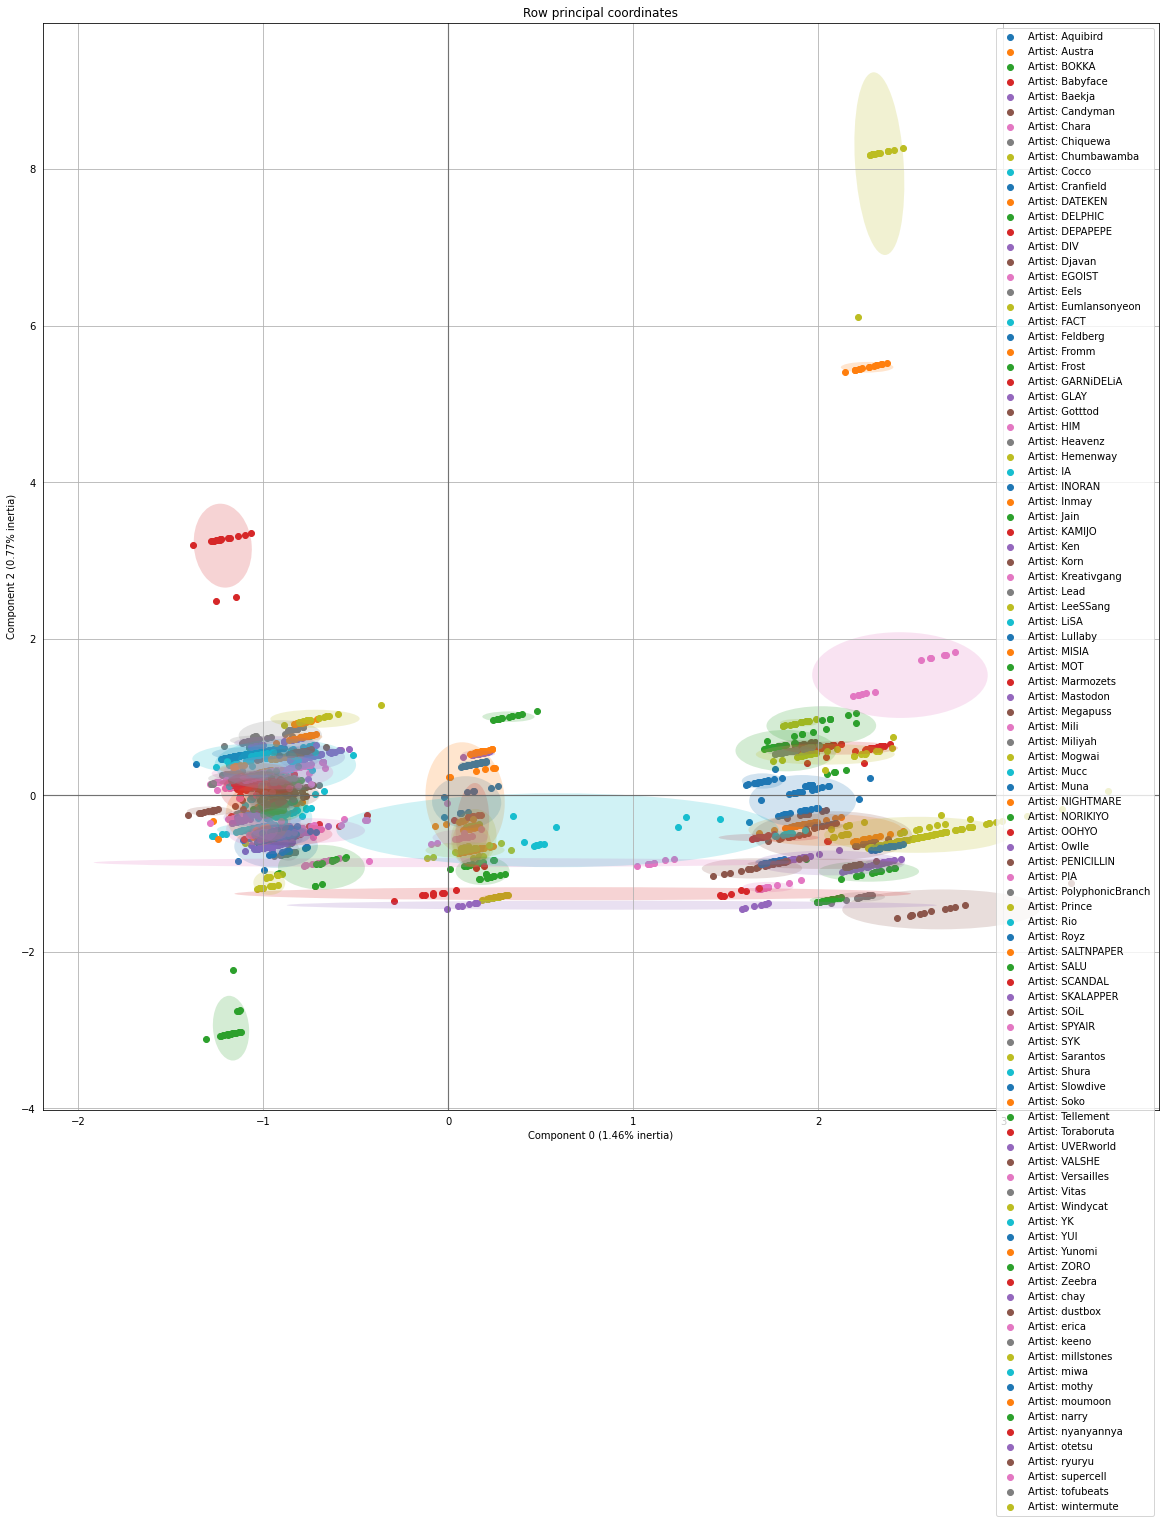

In [219]:
ax = famd.plot_row_coordinates(
    X = raw,
    ax=None,
    figsize=(20, 20),
    x_component=0,
    y_component=2,
    color_labels=["Artist: {}".format(t) for t in raw["artist_name"]],
    ellipse_outline=False,
    ellipse_fill=True,
    show_points=True
)

In [220]:
ax.get_figure().savefig('famd_row_coordinates_100_artists_song_length.svg')

In [221]:
famd.eigenvalues_

array([0.00065898, 0.00048504, 0.00034896])

In [222]:
famd.column_correlations(raw)

,0,1,2
artist_name_Aquibird,0.020098,-0.024324,-0.009118
artist_name_Austra,0.200022,-0.199575,-0.207579
artist_name_BOKKA,0.109727,-0.111920,-0.126132
artist_name_Babyface,0.268845,-0.266729,-0.225780
artist_name_Baekja,0.012978,-0.015083,-0.003186
...,...,...,...
lyricist_toku,-0.027033,0.027386,0.027839
lyricist_toraboruta,-0.023402,0.023013,0.022987
lyricist_uz,-0.013501,0.013495,0.015689
lyricist_wintermute,-0.054178,0.052881,0.026578


In [223]:
continuous_coordinates = pd.DataFrame()
continuous_coordinates["song_id"] = raw["song_id"]
continuous_coordinates = pd.concat([continuous_coordinates, famd.row_coordinates(raw)], axis=1)
continuous_coordinates = continuous_coordinates.rename({0:'X0', 1:'X1', 2:'X2'}, axis=1)

In [224]:
continuous_coordinates

,song_id,X0,X1,X2
655,vK4072/9MUPsaoKaf8/9LmtNuVWz8i8D0sQmEAKO3W4=,-1.078767,0.795495,0.208250
1118,cvRpobXTkdQa7Yxf2lAvYTrLj9RPck5FiHg0KOZSIw0=,2.191764,-0.435968,0.502185
1125,rh35a46NXpktCl3sm7Q/PNPecP1dNs1QEmhWQmLeWPg=,0.188833,-0.748536,0.565635
1742,FPIqsWBqpxx97+CSgXSCOaKkk1L2KgQ6eKKYhrgUg+o=,-0.989763,1.241269,-0.434505
1852,AP3gCgZk4shAxlg4gYIT1mxwo+dqpDroopnT8CJKyLA=,1.861413,-0.472608,0.570857
...,...,...,...,...
2288152,oR8alrUMYXBQc369cafFgK00gvdJzhiUho5+hIQGcqg=,-0.916648,0.165201,-0.629373
2289954,8R2oKRnJFSfDn4QPJ2jPXYbkLRG19rCupuNU8m9SIO4=,0.083141,-0.373721,-0.539500
2290742,E4F826L/3vBfaeY0s7KxW4f7Aj72vm6xKo6n2M8aIAM=,2.147080,1.246312,-0.501505
2293848,5nsiCaZnjJVlas/okuUm93rnD4ZViVTNCIQm2apBdAU=,1.780624,-0.909563,0.588362


In [225]:
train = datasets["train"]

In [226]:
train

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1
...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1


In [227]:
df = pd.merge(train, continuous_coordinates, on='song_id')

In [228]:
df

,msno,song_id,source_system_tab,source_screen_name,source_type,target,X0,X1,X2
0,vMYRcoDAzA0q26Hlz+yzoYC4h9IOTAGWzqrH5ZPt6H4=,T0YJHlRZKVSvHaGTGjzPX5ejFb7cSPyTfJi5qy23Gk8=,my library,Local playlist more,local-library,1,0.061754,-1.113303,-0.231411
1,HVcWdf8CEo9s6qwt5V7TpoPYJfRlQSTA6b7kxEAImpc=,T0YJHlRZKVSvHaGTGjzPX5ejFb7cSPyTfJi5qy23Gk8=,discover,Online playlist more,online-playlist,1,0.061754,-1.113303,-0.231411
2,okSXuuy3m4DLIX3mxXW0f2AqugcrFpTI2IeCLZcP3rA=,T0YJHlRZKVSvHaGTGjzPX5ejFb7cSPyTfJi5qy23Gk8=,discover,Online playlist more,online-playlist,0,0.061754,-1.113303,-0.231411
3,TJL2k7Tq6/O612Rj7MvK/8f3MaB7hx/n+cxRdmrxtn8=,T0YJHlRZKVSvHaGTGjzPX5ejFb7cSPyTfJi5qy23Gk8=,radio,Radio,radio,0,0.061754,-1.113303,-0.231411
4,ilT1ooLHbnB0sxbQWtsgJ0dHgJu8GZqUdupP6asZSJc=,T0YJHlRZKVSvHaGTGjzPX5ejFb7cSPyTfJi5qy23Gk8=,radio,Radio,radio,0,0.061754,-1.113303,-0.231411
...,...,...,...,...,...,...,...,...,...
4873,h2pvQuj/Ly/stn9KnrWUV2ADmJzCoJkQj/ycxd0IIyg=,LKvI9ojhd8kuWmowwA8yA+CYA3JPzMqTDm+CkDA1CM4=,my library,Local playlist more,local-library,0,-0.756526,1.047468,0.386961
4874,h2pvQuj/Ly/stn9KnrWUV2ADmJzCoJkQj/ycxd0IIyg=,eJpyl+jdfjaEQ/yNc0muMiEs15s+m8Q1GAPG2Ftrqyw=,my library,Local playlist more,local-library,0,-0.808407,0.655160,0.362208
4875,/zgv3nZoj0hrNlLdwuaw33DfjmbKXUdGbGwU4oY7foc=,qLTxr+vUaNvJTg0Vol++QfQotZXzFHJN1AlUWzG6d3Q=,my library,Local playlist more,artist,0,-0.898009,-0.022391,0.319458
4876,WcpqlCd/V0fFVNo7NkxhU/ezGPVzHKCC127KzqZx4Yw=,wHE2PAr+/ANx2aqP3MEWh24imPj9SeAkkvSDomUlMyU=,explore,Explore,online-playlist,0,-1.095382,-0.019373,0.233115


In [229]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["user_id"] = le.fit_transform(df["msno"].values)
df.dropna(axis=0, how='any', inplace=True)
df['target'] = df['target'].replace([1], 'liked')
df['target'] = df['target'].replace([0], 'disliked')
for colname in ["X0", "X1", "X2"]:
    le = LabelEncoder()
    df[colname] = le.fit_transform(df[colname].values)
df

,msno,song_id,source_system_tab,source_screen_name,source_type,target,X0,X1,X2,user_id
0,vMYRcoDAzA0q26Hlz+yzoYC4h9IOTAGWzqrH5ZPt6H4=,T0YJHlRZKVSvHaGTGjzPX5ejFb7cSPyTfJi5qy23Gk8=,my library,Local playlist more,local-library,liked,604,64,251,1677
1,HVcWdf8CEo9s6qwt5V7TpoPYJfRlQSTA6b7kxEAImpc=,T0YJHlRZKVSvHaGTGjzPX5ejFb7cSPyTfJi5qy23Gk8=,discover,Online playlist more,online-playlist,liked,604,64,251,536
2,okSXuuy3m4DLIX3mxXW0f2AqugcrFpTI2IeCLZcP3rA=,T0YJHlRZKVSvHaGTGjzPX5ejFb7cSPyTfJi5qy23Gk8=,discover,Online playlist more,online-playlist,disliked,604,64,251,1521
3,TJL2k7Tq6/O612Rj7MvK/8f3MaB7hx/n+cxRdmrxtn8=,T0YJHlRZKVSvHaGTGjzPX5ejFb7cSPyTfJi5qy23Gk8=,radio,Radio,radio,disliked,604,64,251,885
4,ilT1ooLHbnB0sxbQWtsgJ0dHgJu8GZqUdupP6asZSJc=,T0YJHlRZKVSvHaGTGjzPX5ejFb7cSPyTfJi5qy23Gk8=,radio,Radio,radio,disliked,604,64,251,1355
...,...,...,...,...,...,...,...,...,...,...
4873,h2pvQuj/Ly/stn9KnrWUV2ADmJzCoJkQj/ycxd0IIyg=,LKvI9ojhd8kuWmowwA8yA+CYA3JPzMqTDm+CkDA1CM4=,my library,Local playlist more,local-library,disliked,544,681,533,1304
4874,h2pvQuj/Ly/stn9KnrWUV2ADmJzCoJkQj/ycxd0IIyg=,eJpyl+jdfjaEQ/yNc0muMiEs15s+m8Q1GAPG2Ftrqyw=,my library,Local playlist more,local-library,disliked,506,589,520,1304
4875,/zgv3nZoj0hrNlLdwuaw33DfjmbKXUdGbGwU4oY7foc=,qLTxr+vUaNvJTg0Vol++QfQotZXzFHJN1AlUWzG6d3Q=,my library,Local playlist more,artist,disliked,410,385,482,54
4876,WcpqlCd/V0fFVNo7NkxhU/ezGPVzHKCC127KzqZx4Yw=,wHE2PAr+/ANx2aqP3MEWh24imPj9SeAkkvSDomUlMyU=,explore,Explore,online-playlist,disliked,129,386,385,984


In [230]:
df.to_csv("cleaned_song_and_user_data.csv")

In [231]:
mfa = prince.mfa.MFA(
    groups={
        'Song Information': ["X0", "X1", "X2"],
        'User Discovery Info': ["source_system_tab", "source_screen_name", "source_type", "target"] 
    },
    n_components=3,
    n_iter=5,
    copy=True,
    check_input=True,
    random_state=42
)
mfa = mfa.fit(df.drop(['song_id', 'msno', 'user_id'], axis='columns'))

In [232]:
mfa.row_coordinates(df)

,0,1,2
0,-0.472316,-0.897724,1.380803
1,1.043762,0.225749,0.198021
2,1.186634,0.565844,0.137917
3,-0.349961,2.874691,2.361553
4,-0.349961,2.874691,2.361553
...,...,...,...
4873,-1.578619,-0.482252,-0.574435
4874,-1.363437,-0.510393,-0.281441
4875,-0.775095,-0.561378,0.356140
4876,1.043938,0.279061,-0.469888


## gradient boost

alternative to pca above

In [234]:
import lightgbm as lgb
import gc

In [275]:
sei = pd.read_csv('../data/song_extra_info.csv')
members = pd.read_csv('../data/members.csv', parse_dates=['registration_init_time','expiration_date'])
songs = pd.read_csv('../data/songs.csv')
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [257]:
members['expiration_year'] = members['expiration_date'].dt.year
members.drop(columns = ['registration_init_time' , 'expiration_date'] , inplace = True)
members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)
members['registration_year'] = members['registration_init_time'].dt.year
members.head()

,msno,city,bd,gender,registered_via,membership_days,registration_year,expiration_year
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2223,2011,2017
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,725,2015,2017
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,457,2016,2017
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,1,2015,2015
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,138,2017,2017


In [258]:
train = train.merge(songs , on='song_id' , how='left')
train = train.merge(members , on = 'msno' , how='left')
train = train.merge(sei , on = 'song_id' , how='left')
test  = test.merge(songs , on='song_id' , how='left')
test = test.merge(members , on = 'msno' , how = 'left')
test =  test.merge(sei , on = 'song_id' , how = 'left')

3116

In [259]:
test['song_length'].fillna(test['song_length'].mean() , inplace = True)
test['song_length'] = test['song_length'].astype(np.uint32)
test['language'].fillna(test['language'].mode().values[0] , inplace= True)
test['language'] = test['language'].astype(np.int8)

train['song_length'].fillna(train['song_length'].mean() , inplace = True)
train['song_length'] = train['song_length'].astype(np.uint32)
train['language'].fillna(train['language'].mode().values[0] , inplace= True)
train['language'] = train['language'].astype(np.int8)

print(train.columns)
train.head()

False    0.999985
True     0.000015
Name: song_length, dtype: float64
False    0.99998
True     0.00002
Name: language, dtype: float64
Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'city', 'bd', 'gender',
       'registered_via', 'membership_days', 'registration_year',
       'expiration_year', 'name', 'isrc', 'year'],
      dtype='object')


,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,city,bd,gender,registered_via,membership_days,registration_year,expiration_year,name,isrc,year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471,359,Bastille,Dan Smith| Mark Crew,...,1,0,NaN,7,2103,2012,2017,Good Grief,GBUM71602854,2016.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584,1259,Various Artists,NaN,...,13,24,female,9,2301,2011,2017,Lords of Cardboard,US3C69910183,1999.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,13,24,female,9,2301,2011,2017,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,2006.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512,1019,Soundway,Kwadwo Donkoh,...,13,24,female,9,2301,2011,2017,Disco Africa,GBUQH1000063,2010.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,...,1,0,NaN,7,2103,2012,2017,Sleep Without You,QM3E21606003,2016.0


In [260]:
train['genre_ids'].fillna('no_genre_id' , inplace= True)
train['genre_ids_count'] = train['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)
test['genre_ids'].fillna('no_genre_id' , inplace= True)
test['genre_ids_count'] = test['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)

False    0.983944
True     0.016056
Name: genre_ids, dtype: float64


In [261]:
def artist_count(art) -> int:
    """
    get number of artists
    """
    return 0 if art == 'no_artist_name' else art.count('|')+art.count('/') + art.count('//') + art.count(';') + 1

train['artist_name'].isnull().value_counts()
train['artist_name'].fillna('no_artist_name' , inplace = True)
train['artist_count'] = train['artist_name'].apply(lambda x : artist_count(x)).astype(np.int8)
test['artist_name'].fillna('no_artist_name' , inplace = True)
test['artist_count'] = test['artist_name'].apply(lambda x : artist_count(x)).astype(np.int8)

In [277]:
train_col = list(train.columns)
test_col = list(test.columns)

label_encoded = ['source_system_tab', 'source_screen_name',
       'source_type','gender']
drop = ['msno', 'song_id' , 'isrc','artist_name',
       'composer', 'lyricist','name','genre_ids']
min_max_scaling = ['number_of_time_played', 'user_activity_msno','membership_days', 'song_length']

for feature in label_encoded:
    le = LabelEncoder()
    le.fit(train[feature].values + test[feature].values)
    train[f] = le.transform(list(train[feature].values))
    test[f] = le.transform(list(test[feature].values))

for feature in min_max_scaling:
    ms = MinMaxScaler()
    train[f] = ms.fit_transform(train[[feature]])
    test[f] = ms.transform(test[[feature]])

In [266]:
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

In [267]:
print(train.columns)
train.head(10)

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'city', 'bd', 'gender',
       'registered_via', 'membership_days', 'registration_year',
       'expiration_year', 'name', 'isrc', 'year', 'genre_ids_count',
       'artist_count', 'composer_count', 'lyricist_count',
       'number_of_time_played', 'user_activity_msno'],
      dtype='object')


,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,expiration_year,name,isrc,year,genre_ids_count,artist_count,composer_count,lyricist_count,number_of_time_played,user_activity_msno
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,1,7,7,1,0.018901,359,Bastille,Dan Smith| Mark Crew,...,2017,Good Grief,GBUM71602854,2016.0,1,1,2,0,0.015316,0.896237
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,3,8,4,1,0.026100,1259,Various Artists,no_composer,...,2017,Lords of Cardboard,US3C69910183,1999.0,1,1,0,0,0.000000,0.092360
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,3,8,4,1,0.020645,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,2017,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,2006.0,1,1,1,0,0.000215,0.092360
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,3,8,4,1,0.023420,1019,Soundway,Kwadwo Donkoh,...,2017,Disco Africa,GBUQH1000063,2010.0,1,1,1,0,0.000000,0.092360
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,1,7,7,1,0.017180,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,...,2017,Sleep Without You,QM3E21606003,2016.0,1,1,3,0,0.029416,0.896237
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,1,7,7,1,0.022710,1259,Desiigner,Sidney Selby| Adnan Khan,...,2017,Panda,USUM71601094,2016.0,1,1,2,0,0.079230,0.896237
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,3,8,4,1,0.021068,465,BIGBANG TAEYANG,TEDDY| DEE.P| Rebecca Johnson,...,2017,眼| 鼻| 口 (Eyes| Nose| Lips),TWA531400512,2014.0,1,1,3,2,0.276839,0.092360
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,1,7,7,1,0.016564,1011,Thomas Rhett,Thomas Rhett| Rhett Akins| Ben Hayslip,...,2017,Star Of The Show,USLXJ1607334,2016.0,1,1,3,0,0.020470,0.896237
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,3,8,3,1,0.025582,2022,OneRepublic,Ryan Tedder,...,2018,Dreaming Out Loud,USUM70759544,2007.0,1,1,1,0,0.002147,0.106423
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,3,8,3,1,0.023592,465,OneRepublic,Ryan Tedder,...,2018,Counting Stars,USUM71301306,2013.0,1,1,1,0,0.052748,0.106423


In [271]:
X_train = train.drop(columns = ['target'] , axis = 1)
Y_train = train['target'].values
X_test = test.drop(columns = ['id'] , axis = 1)

ids = test['id'].values
train_set = lgb.Dataset(X_train , Y_train)

In [272]:
model = lgb.train({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'learning_rate': 0.3 ,
    'verbose': 0,
    'num_leaves': 108,
    'bagging_fraction': 0.95,
    'bagging_freq': 1,
    'bagging_seed': 1,
    'feature_fraction': 0.9,
    'feature_fraction_seed': 1,
    'max_bin': 256,
    'max_depth': 10,
    'num_rounds': 200,
    'metric' : 'auc'
}, train_set=train_set,  valid_sets=train_set, verbose_eval=5)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.856083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[5]	training's auc: 0.736167
[10]	training's auc: 0.748005
[15]	training's auc: 0.754421
[20]	training's auc: 0.759233
[25]	training's auc: 0.762544
[30]	training's auc: 0.765713
[35]	training's auc: 0.768136
[40]	training's auc: 0.771355
[45]	training's auc: 0.773379
[50]	training's auc: 0.775447
[55]	training's auc: 0.777483
[60]	training's auc: 0.779126
[65]	training's auc: 0.780748
[70]	training's auc: 0.782426
[75]	training's auc: 0.784057
[80]	training's auc: 0.785748
[85]	training's auc: 0.787138
[90]	training's auc: 0.78843
[95]	training's auc: 0.789651
[100]	training's auc: 0.790847
[105]	training's auc: 0.791955
[110]	training's auc: 0.792972
[115]	training's auc: 0.793971
[120]	training's auc: 0.794948
[125]	training's auc: 0.795891
[130]	training's auc: 0.798364
[135]	training's auc: 0.799259
[140]	training's au

In [276]:
predictions = model.predict(X_test)
print(predictions)
print('Saving Predictions')
submission = pd.DataFrame({
    'id': ids,
    'target': pred_test
})
submission['target'] = pred_test
submission.to_csv('submission.csv' , index = False , float_format ='%.5f' )
submission.head()

[0.38419875 0.31085878 0.19812878 ... 0.42768898 0.38944534 0.39090245]
Saving Predictions


,id,target
0,0,0.384199
1,1,0.310859
2,2,0.198129
3,3,0.119010
4,4,0.097116
